In [1]:
# ==========================================================
# BLOCCO 1: Data Cleaning e Aggregazione ottimizzato (ZeekDataFall22)
# ==========================================================

import os
import glob
import pandas as pd
from tqdm import tqdm

# Percorso cartella parquet
folder_path = r"C:\Users\maria\Desktop\Zeek_ML\UWF-ZeekDataFall22"
parquet_files = glob.glob(os.path.join(folder_path, "*.parquet"))

# -----------------------
# 1️⃣ Caricamento incrementale
# -----------------------
dfs = []
for file in tqdm(parquet_files, desc="Caricamento file parquet"):
    dfs.append(pd.read_parquet(file))
data = pd.concat(dfs, ignore_index=True)
print(f"Totale righe iniziali: {len(data)}")
print(f"Totale colonne iniziali: {data.shape[1]}")

# -----------------------
# 2️⃣ Conversione object → category per risparmio RAM
# -----------------------
for col in data.select_dtypes(include=['object']).columns:
    data[col] = data[col].astype('category')

# -----------------------
# 3️⃣ Analisi valori mancanti
# -----------------------
col_summary = pd.DataFrame({
    'dtype': data.dtypes,
    'num_missing': data.isna().sum(),
    'perc_missing': data.isna().mean() * 100
}).sort_values('perc_missing', ascending=False)
display(col_summary)

# -----------------------
# 4️⃣ Eliminazione colonne con troppi NaN (>50%)
# -----------------------
threshold = 50
cols_to_drop = col_summary[col_summary['perc_missing'] > threshold].index.tolist()
if cols_to_drop:
    data.drop(columns=cols_to_drop, inplace=True)
    print(f"Colonne eliminate per troppi NaN (> {threshold}%): {cols_to_drop}")
else:
    print("Nessuna colonna da eliminare per troppi NaN.")

# -----------------------
# 5️⃣ Rimozione duplicati (solo colonne chiave per risparmio RAM)
# -----------------------
subset_cols = ['uid', 'ts', 'orig_bytes', 'resp_bytes'] if 'uid' in data.columns else None
duplicates_before = data.duplicated(subset=subset_cols).sum()
data = data.drop_duplicates(subset=subset_cols)
print(f"Duplicati rimossi: {duplicates_before}")

# -----------------------
# 6️⃣ Imputazione valori mancanti
# -----------------------
num_cols = data.select_dtypes(include=['int64','float64']).columns
cat_cols = data.select_dtypes(include=['category']).columns

for col in num_cols:
    if data[col].isna().any():
        data[col].fillna(data[col].mean(), inplace=True)
for col in cat_cols:
    if data[col].isna().any():
        mode_val = data[col].mode()
        data[col].fillna(mode_val[0] if not mode_val.empty else 'unknown', inplace=True)

# -----------------------
# 7️⃣ Aggregazioni session-level features
# -----------------------
if 'uid' not in data.columns:
    data['uid'] = range(len(data))

session_features = data.groupby('uid').agg(
    total_orig_bytes=('orig_bytes', 'sum'),
    total_resp_bytes=('resp_bytes', 'sum'),
    total_orig_pkts=('orig_pkts', 'sum'),
    total_resp_pkts=('resp_pkts', 'sum'),
    mean_duration=('duration', 'mean')
).reset_index()

data = pd.merge(data, session_features, on='uid', how='left')
print(f"Totale sessioni aggregate: {session_features.shape[0]}")

# -----------------------
# 8️⃣ Anteprima finale
# -----------------------
display(data.head())
print("✅ Data Cleaning e Aggregazioni completati.")

Caricamento file parquet: 100%|██████████| 13/13 [00:02<00:00,  6.44it/s]


Totale righe iniziali: 700340
Totale colonne iniziali: 25


,dtype,num_missing,perc_missing
service,category,317407,45.321844
duration,float64,317051,45.271011
orig_bytes,float64,317051,45.271011
resp_bytes,float64,317051,45.271011
history,category,8206,1.171717
community_id,category,0,0.000000
proto,category,0,0.000000
label_technique,category,0,0.000000
label_tactic,category,0,0.000000
datetime,datetime64[ns],0,0.000000


Nessuna colonna da eliminare per troppi NaN.
Duplicati rimossi: 39967


C:\Users\maria\AppData\Local\Temp\ipykernel_14756\286670642.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  session_features = data.groupby('uid').agg(


Totale sessioni aggregate: 660373


,community_id,conn_state,duration,history,src_ip_zeek,src_port_zeek,dest_ip_zeek,dest_port_zeek,local_orig,local_resp,...,uid,datetime,label_tactic,label_technique,label_binary,total_orig_bytes,total_resp_bytes,total_orig_pkts,total_resp_pkts,mean_duration
0,1:ktX8uiwrFpzrBHnE1G51yTAiiQo=,S1,41.878964,ShAdD,143.88.10.11,42296,143.88.10.13,9999,False,False,...,CrA3emsiAM5XvugO6,2022-10-23 22:07:45.793,Persistence,T1546,True,11.0,1847.0,7,5,41.878964
1,1:52yAKDtnHSPDIljwNPlA+UWODdA=,SF,0.041849,ShAdDFaf,143.88.10.11,57042,143.88.10.16,9999,False,False,...,CqO92B3QWHYhyPdtse,2022-10-05 18:14:34.531,Execution,T1059,True,114.0,73.0,9,6,0.041849
2,1:CLE/zfbKMSEi1spOm7y0JJKUgO4=,SF,0.046801,ShAdDFaf,143.88.10.11,57044,143.88.10.16,9999,False,False,...,CPwSIpstvV2fZBc4k,2022-10-05 18:14:51.275,Execution,T1059,True,1014.0,73.0,9,6,0.046801
3,1:TTpmQx1wKxVI3KmlIDAsdr/5rXg=,S1,0.012059,ShAdDa,143.88.10.11,57046,143.88.10.16,9999,False,False,...,Cy4bYOmyBBGRSvod9,2022-10-05 18:14:57.059,Execution,T1059,True,3008.0,51.0,6,3,0.012059
4,1:VhB7MbbJ52hjItNqXYgI9n8660Q=,SF,0.013730,Dd,143.88.20.12,68,143.88.20.1,67,False,False,...,CMcgot3HfOuCDV3s11,2022-10-04 11:40:45.900,Collection,T1557,True,600.0,600.0,2,2,0.013730


✅ Data Cleaning e Aggregazioni completati.


In [2]:
# ==========================================================
# BLOCCO 2: Controllo valori nulli e riepilogo colonne/feature
# ==========================================================

# Controllo valori nulli residui
null_counts = data.isna().sum()
null_cols = null_counts[null_counts > 0]

if len(null_cols) == 0:
    print("✅ Non ci sono valori nulli residui.")
else:
    print("⚠️ Colonne con valori nulli residui:")
    display(null_cols)

# Riepilogo colonne e feature rimaste dopo data cleaning e aggregazioni
print("\n📊 Colonne e feature disponibili per l'analisi:")
for i, col in enumerate(data.columns):
    print(f"{i+1}. {col}")

# Opzionale: possiamo separare feature numeriche e categoriali per la fase successiva
num_features = data.select_dtypes(include=['int64','float64']).columns.tolist()
cat_features = data.select_dtypes(include=['object','category']).columns.tolist()

print("\n🔹 Feature numeriche:")
print(num_features)
print("\n🔹 Feature categoriali:")
print(cat_features)
# --------------------------
# Salvataggio feature categoriali
# --------------------------
cat_features_df = data[cat_features].copy()
cat_features_df.to_parquet(r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\categorical_features.parquet", index=False)
print(f"💾 Feature categoriali salvate: {cat_features_df.shape[1]} colonne, {cat_features_df.shape[0]} righe")

✅ Non ci sono valori nulli residui.

📊 Colonne e feature disponibili per l'analisi:
1. community_id
2. conn_state
3. duration
4. history
5. src_ip_zeek
6. src_port_zeek
7. dest_ip_zeek
8. dest_port_zeek
9. local_orig
10. local_resp
11. missed_bytes
12. orig_bytes
13. orig_ip_bytes
14. orig_pkts
15. proto
16. resp_bytes
17. resp_ip_bytes
18. resp_pkts
19. service
20. ts
21. uid
22. datetime
23. label_tactic
24. label_technique
25. label_binary
26. total_orig_bytes
27. total_resp_bytes
28. total_orig_pkts
29. total_resp_pkts
30. mean_duration

🔹 Feature numeriche:
['duration', 'src_port_zeek', 'dest_port_zeek', 'missed_bytes', 'orig_bytes', 'orig_ip_bytes', 'orig_pkts', 'resp_bytes', 'resp_ip_bytes', 'resp_pkts', 'ts', 'total_orig_bytes', 'total_resp_bytes', 'total_orig_pkts', 'total_resp_pkts', 'mean_duration']

🔹 Feature categoriali:
['community_id', 'conn_state', 'history', 'src_ip_zeek', 'dest_ip_zeek', 'proto', 'service', 'uid', 'label_tactic', 'label_technique', 'label_binary']
💾 F

📊 Analisi esplorativa della label_tactic...

Distribuzione label_tactic:


,count,%
label_tactic,,
none,350339,53.05
Resource Development,262409,39.74
Reconnaissance,28661,4.34
Discovery,16020,2.43
Defense Evasion,2894,0.44
Initial Access,16,0.00
Command and Control,14,0.00
Execution,8,0.00
Lateral Movement,6,0.00


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\maria\AppData\Local\Temp\ipykernel_14756\2105770508.py:26: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


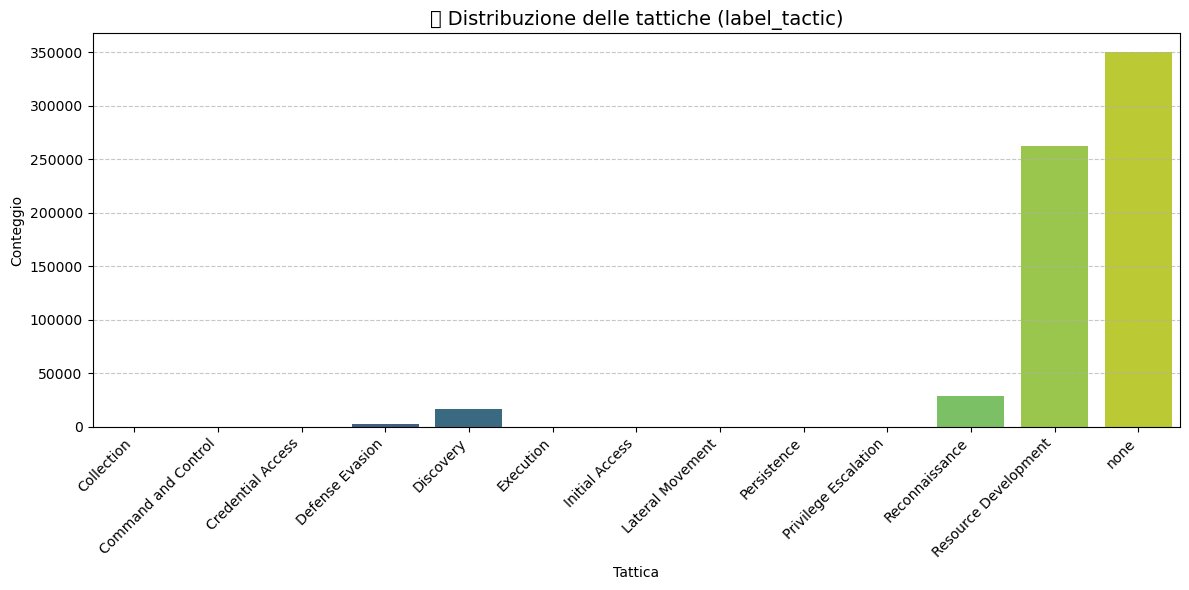


🔹 Percentuale cumulativa delle tattiche:


,count,%,cumulative_%
label_tactic,,,
none,350339,53.05,53.05
Resource Development,262409,39.74,92.79
Reconnaissance,28661,4.34,97.13
Discovery,16020,2.43,99.56
Defense Evasion,2894,0.44,100.00
Initial Access,16,0.00,100.00
Command and Control,14,0.00,100.00
Execution,8,0.00,100.00
Lateral Movement,6,0.00,100.00



🔹 Classi principali (>5% del totale):


,count,%,cumulative_%
label_tactic,,,
none,350339,53.05,53.05
Resource Development,262409,39.74,92.79


In [3]:
# ==========================================================
# BLOCCO 3: Analisi esplorativa della label_tactic
# ==========================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("📊 Analisi esplorativa della label_tactic...\n")

# 1️⃣ Distribuzione generale
tactic_counts = data['label_tactic'].value_counts()
tactic_perc = tactic_counts / tactic_counts.sum() * 100
tactic_summary = pd.concat([tactic_counts, tactic_perc.round(2)], axis=1)
tactic_summary.columns = ['count', '%']
print("Distribuzione label_tactic:")
display(tactic_summary)

# 2️⃣ Visualizzazione grafica
plt.figure(figsize=(12,6))
sns.barplot(x=tactic_counts.index, y=tactic_counts.values, palette='viridis')
plt.title("📊 Distribuzione delle tattiche (label_tactic)", fontsize=14)
plt.xlabel("Tattica")
plt.ylabel("Conteggio")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3️⃣ Eventuali analisi aggiuntive
# Percentuale cumulativa
tactic_summary['cumulative_%'] = tactic_summary['%'].cumsum()
print("\n🔹 Percentuale cumulativa delle tattiche:")
display(tactic_summary[['count','%','cumulative_%']])

# 4️⃣ Evidenzia classi principali (>5% del totale)
main_classes = tactic_summary[tactic_summary['%'] > 5]
print("\n🔹 Classi principali (>5% del totale):")
display(main_classes)


⚙️ Rimozione del traffico benigno ('none') e aggiornamento distribuzioni...

📋 Totale record: 660373
⚠️ Campioni benigni ('none') rilevati: 350339 (53.05%)

📊 Distribuzione 'label_technique' PRIMA della rimozione dei benigni:


,Conteggio,Percentuale (%)
label_technique,,
none,350339,53.05
T1587,262409,39.74
T1592,20382,3.09
T1046,16020,2.43
T1595,8104,1.23
T1548,2893,0.44
T1589,135,0.02
T1590,40,0.01
T1071,12,0.00


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\maria\AppData\Local\Temp\ipykernel_14756\2400587127.py:45: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


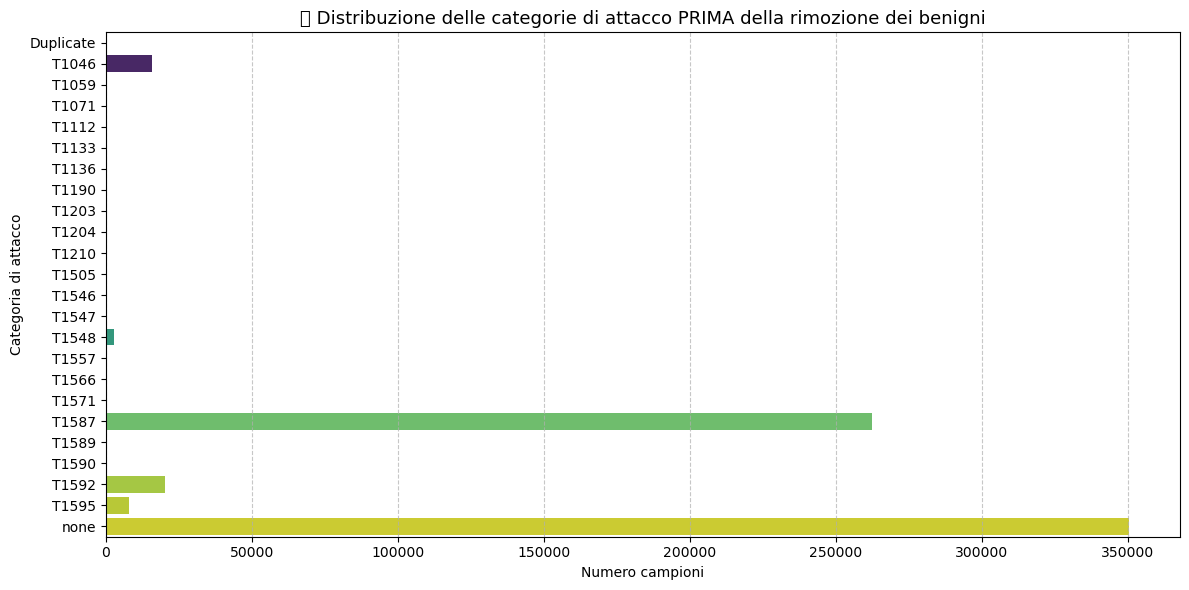

✅ Dopo la rimozione: 310034 righe rimanenti (46.95% del totale).

📊 Distribuzione 'label_technique' DOPO la rimozione dei benigni:


,Conteggio,Percentuale (%)
label_technique,,
T1587,262409,84.64
T1592,20382,6.57
T1046,16020,5.17
T1595,8104,2.61
T1548,2893,0.93
T1589,135,0.04
T1590,40,0.01
T1071,12,0.00
T1566,9,0.00


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\maria\AppData\Local\Temp\ipykernel_14756\2400587127.py:73: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


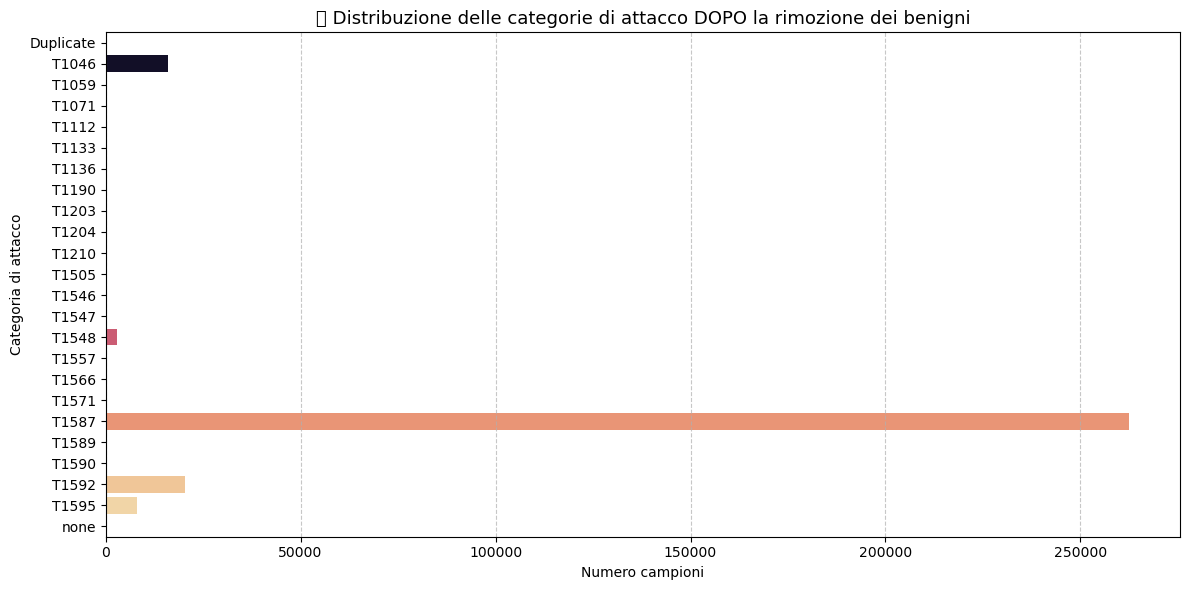


📊 Distribuzione 'label_tactic' DOPO la rimozione dei benigni:


,Conteggio,Percentuale (%)
label_tactic,,
Resource Development,262409,84.64
Reconnaissance,28661,9.24
Discovery,16020,5.17
Defense Evasion,2894,0.93
Initial Access,16,0.01
Command and Control,14,0.00
Execution,8,0.00
Lateral Movement,6,0.00
Persistence,5,0.00


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\maria\AppData\Local\Temp\ipykernel_14756\2400587127.py:95: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


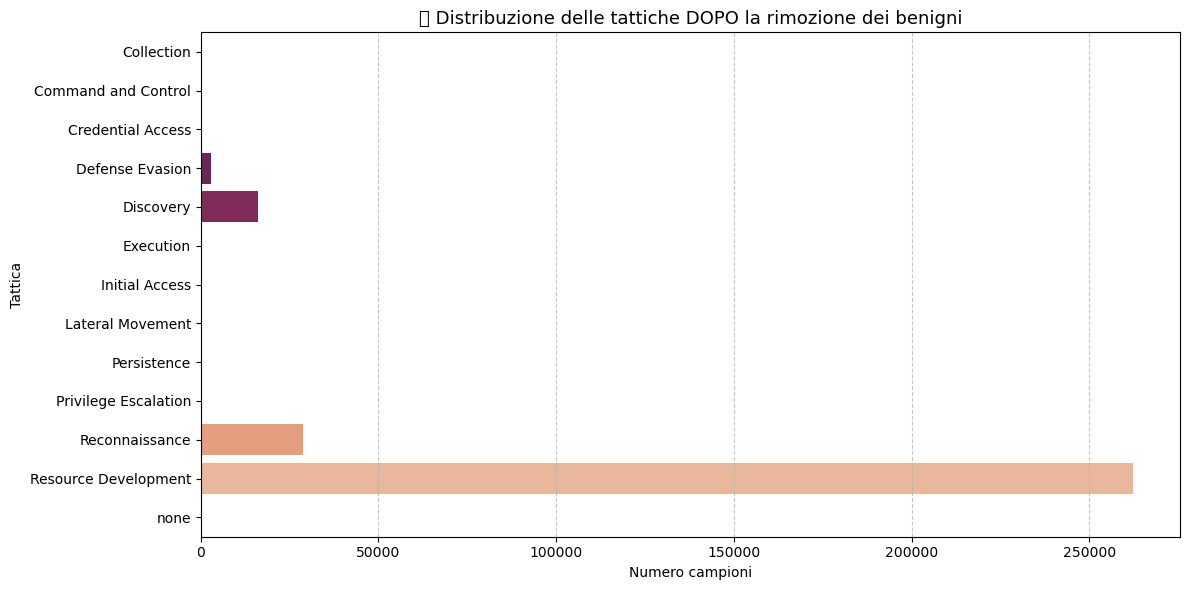

In [4]:
# ==========================================================
# BLOCCO 4: Rimozione traffico benigno ("none") e analisi post-rimozione
# ==========================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("⚙️ Rimozione del traffico benigno ('none') e aggiornamento distribuzioni...\n")

# ---------------------------
# 1️⃣ Controllo colonne obbligatorie
# ---------------------------
if 'label_technique' not in data.columns:
    raise KeyError("⚠️ Manca la colonna 'label_technique' nel dataset caricato.")
if 'label_tactic' not in data.columns:
    print("⚠️ Colonna 'label_tactic' non trovata: verrà saltata l'analisi tattiche post-rimozione.")

# ---------------------------
# 2️⃣ Analisi preliminare prima della rimozione
# ---------------------------
total_count = len(data)
none_count = (data['label_technique'] == 'none').sum()
perc_none = (none_count / total_count) * 100

print(f"📋 Totale record: {total_count}")
print(f"⚠️ Campioni benigni ('none') rilevati: {none_count} ({perc_none:.2f}%)\n")

# Tabella di riepilogo pre-rimozione
tech_counts_before = data['label_technique'].value_counts()
tech_perc_before = (tech_counts_before / total_count * 100).round(2)
tech_summary_before = pd.DataFrame({
    'Conteggio': tech_counts_before,
    'Percentuale (%)': tech_perc_before
})
print("📊 Distribuzione 'label_technique' PRIMA della rimozione dei benigni:")
display(tech_summary_before)

# Grafico pre-rimozione
plt.figure(figsize=(12,6))
sns.barplot(x=tech_counts_before.values, y=tech_counts_before.index, palette='viridis')
plt.title("📊 Distribuzione delle categorie di attacco PRIMA della rimozione dei benigni", fontsize=13)
plt.xlabel("Numero campioni")
plt.ylabel("Categoria di attacco")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ---------------------------
# 3️⃣ Rimozione traffico benigno
# ---------------------------
data = data[data['label_technique'] != 'none'].reset_index(drop=True)
print(f"✅ Dopo la rimozione: {len(data)} righe rimanenti ({len(data)/total_count*100:.2f}% del totale).\n")

# ---------------------------
# 4️⃣ Analisi post-rimozione
# ---------------------------
tech_counts_after = data['label_technique'].value_counts()
tech_perc_after = (tech_counts_after / len(data) * 100).round(2)
tech_summary_after = pd.DataFrame({
    'Conteggio': tech_counts_after,
    'Percentuale (%)': tech_perc_after
})
print("📊 Distribuzione 'label_technique' DOPO la rimozione dei benigni:")
display(tech_summary_after)

# Grafico post-rimozione
plt.figure(figsize=(12,6))
sns.barplot(x=tech_counts_after.values, y=tech_counts_after.index, palette='magma')
plt.title("📊 Distribuzione delle categorie di attacco DOPO la rimozione dei benigni", fontsize=13)
plt.xlabel("Numero campioni")
plt.ylabel("Categoria di attacco")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ---------------------------
# 5️⃣ Analisi tactic (solo se disponibile)
# ---------------------------
if 'label_tactic' in data.columns:
    tactic_counts_after = data['label_tactic'].value_counts()
    tactic_perc_after = (tactic_counts_after / len(data) * 100).round(2)
    tactic_summary_after = pd.DataFrame({
        'Conteggio': tactic_counts_after,
        'Percentuale (%)': tactic_perc_after
    })
    print("\n📊 Distribuzione 'label_tactic' DOPO la rimozione dei benigni:")
    display(tactic_summary_after)

    plt.figure(figsize=(12,6))
    sns.barplot(x=tactic_counts_after.values, y=tactic_counts_after.index, palette='rocket')
    plt.title("📊 Distribuzione delle tattiche DOPO la rimozione dei benigni", fontsize=13)
    plt.xlabel("Numero campioni")
    plt.ylabel("Tattica")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


✅ Feature con varianza significativa: ['ts', 'dest_port_zeek', 'src_port_zeek', 'resp_ip_bytes', 'orig_ip_bytes', 'resp_bytes', 'total_resp_bytes', 'orig_bytes', 'total_orig_bytes', 'missed_bytes', 'resp_pkts', 'total_resp_pkts', 'orig_pkts', 'total_orig_pkts', 'duration', 'mean_duration']
⚠️ Numero di outlier trovati per feature:


ts                  47722
dest_port_zeek          0
src_port_zeek           2
resp_ip_bytes       22952
orig_ip_bytes       47855
resp_bytes          23902
total_resp_bytes    23902
orig_bytes          23902
total_orig_bytes    23902
missed_bytes            8
resp_pkts           22952
total_resp_pkts     22952
orig_pkts           23741
total_orig_pkts     23741
duration            23902
mean_duration       23902
dtype: int64

🏗️ Applicazione trasformazioni per gestire outlier...


📄 REPORT FINALE - Dataset post Winsorization + log

🔹 Statistiche descrittive:


,count,mean,std,min,25%,50%,75%,max
ts,310034.0,2.123226e+01,0.000273,2.123128e+01,2.123236e+01,2.123236e+01,2.123236e+01,2.123236e+01
dest_port_zeek,310034.0,9.471707e+00,1.941075,3.988984e+00,9.084891e+00,1.021709e+01,1.074712e+01,1.107874e+01
src_port_zeek,310034.0,1.079624e+01,0.114324,1.050206e+01,1.069612e+01,1.077306e+01,1.090436e+01,1.099638e+01
resp_ip_bytes,310034.0,4.380596e-01,1.554144,9.999995e-07,9.999995e-07,9.999995e-07,9.999995e-07,6.734592e+00
orig_ip_bytes,310034.0,3.923842e+00,0.451445,3.713572e+00,3.806662e+00,3.806662e+00,3.806662e+00,6.357842e+00
resp_bytes,310034.0,4.634506e+00,0.297487,4.556757e+00,4.556757e+00,4.556757e+00,4.556757e+00,6.437752e+00
total_resp_bytes,310034.0,4.634506e+00,0.297487,4.556757e+00,4.556757e+00,4.556757e+00,4.556757e+00,6.437752e+00
orig_bytes,310034.0,4.781767e+00,0.148683,4.477337e+00,4.774184e+00,4.774184e+00,4.774184e+00,6.013715e+00
total_orig_bytes,310034.0,4.781767e+00,0.148683,4.477337e+00,4.774184e+00,4.774184e+00,4.774184e+00,6.013715e+00
missed_bytes,310034.0,9.999995e-07,0.000000,9.999995e-07,9.999995e-07,9.999995e-07,9.999995e-07,9.999995e-07



📝 Motivazione trasformazione:
- Alcune feature avevano outlier estremi che potevano distorcere le distribuzioni.
- Winsorization: limita i valori ai percentili 1% e 99%, riducendo l'impatto degli outlier.
- Log-transform: riduce l'asimmetria e migliora la stabilità numerica.
- Il dataset risultante ha distribuzioni più compatte e valori pronti per scaling/normalizzazione.


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

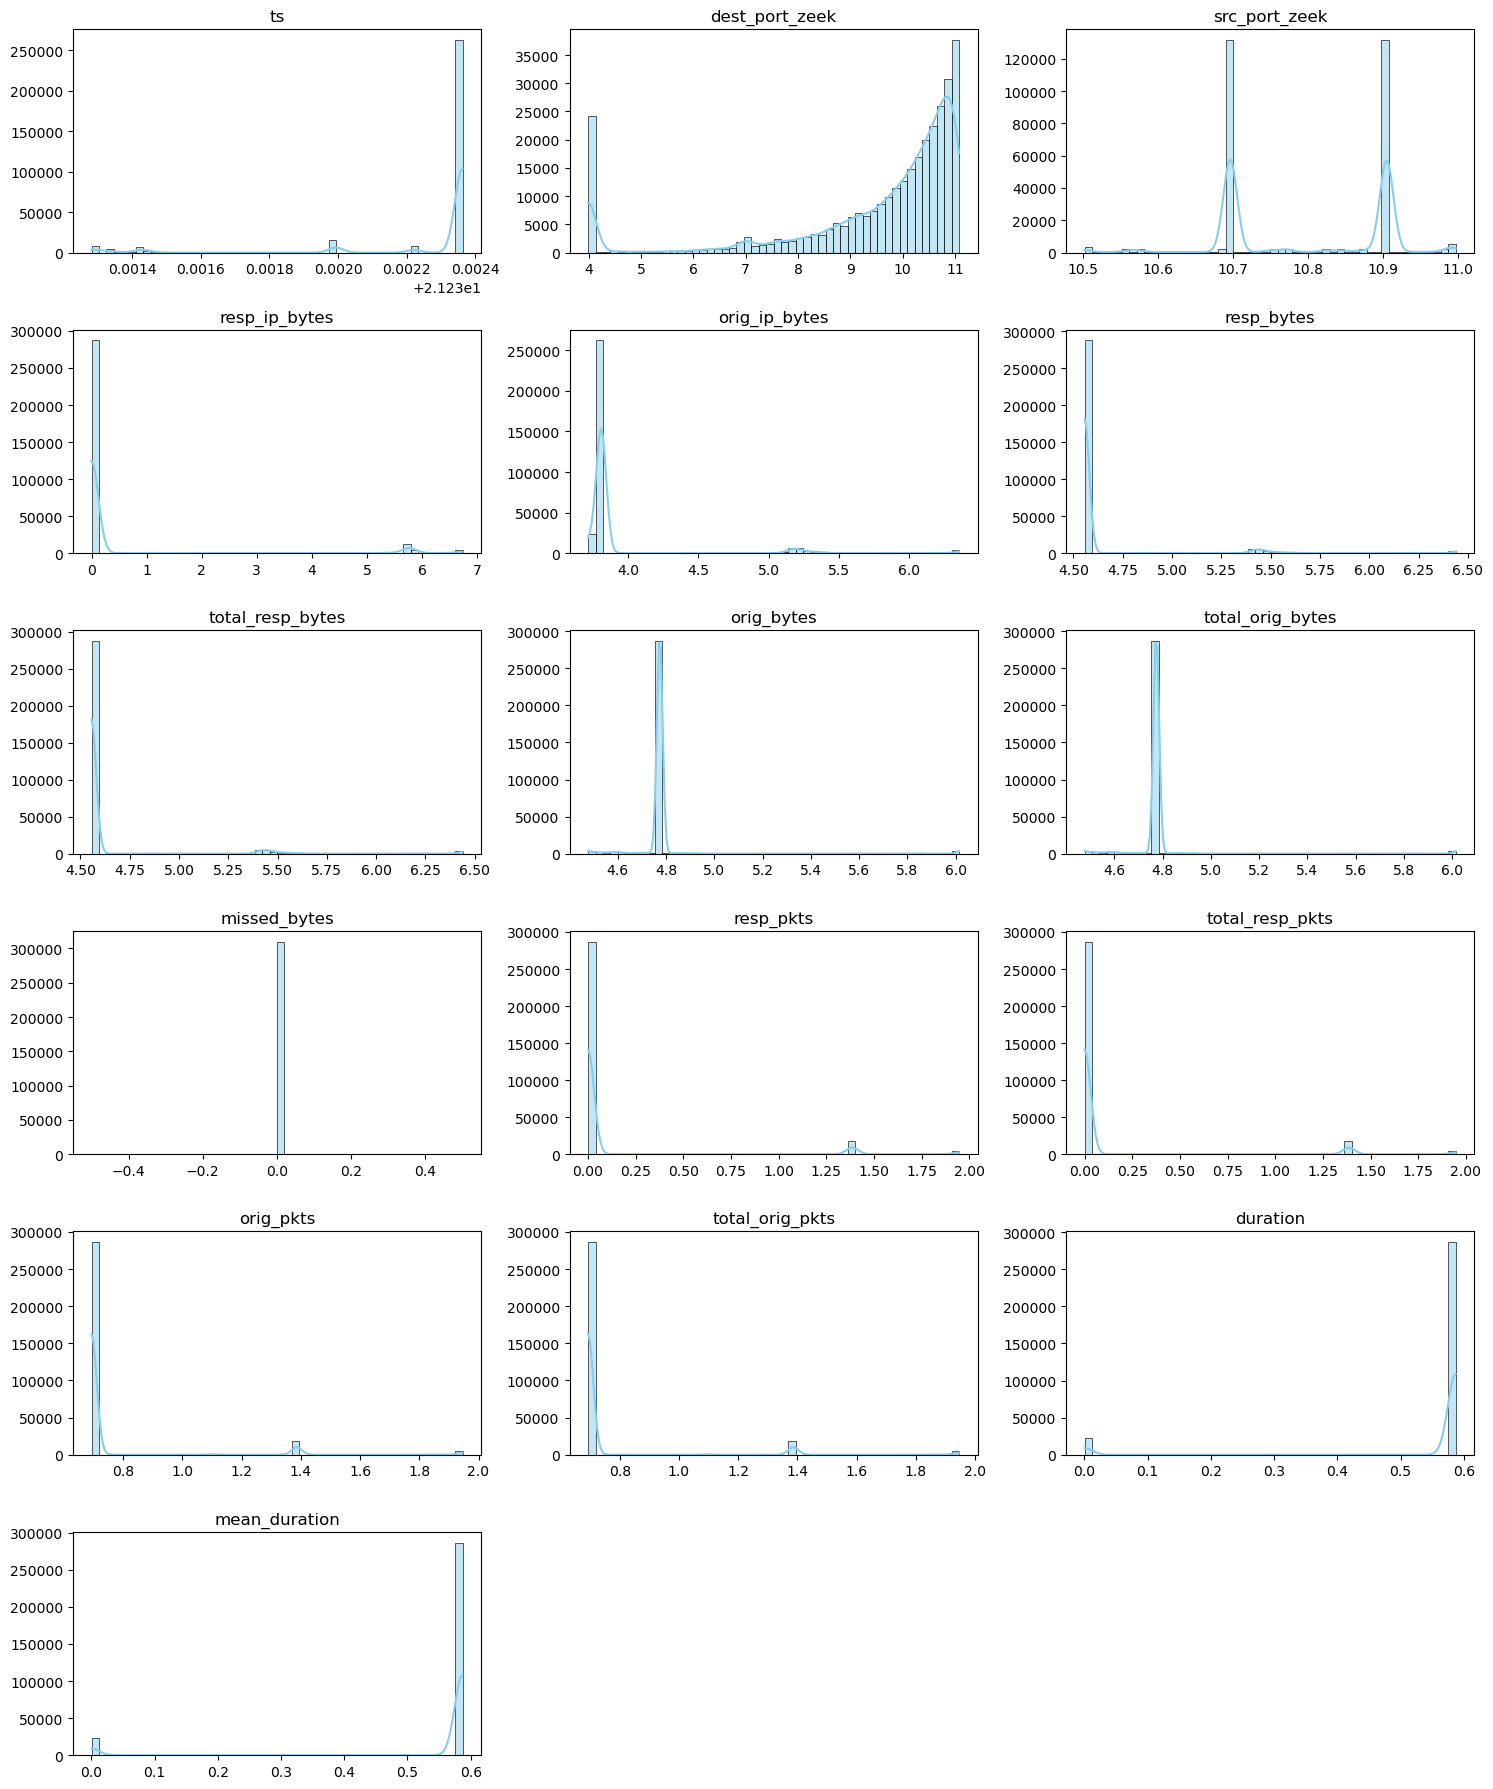

In [5]:
# ==========================================================
# BLOCCO 5: Analisi feature numeriche, gestione outlier e trasformazione robusta
# ==========================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

# ================================
# Step 0: Pulizia sicura della label_binary
# ================================
data['label_binary_clean'] = data['label_binary'].map({True:1, False:0, 'True':1, 'False':0, 1:1, 0:0})
data = data.dropna(subset=['label_binary_clean'])
data['label_binary'] = data['label_binary_clean'].astype(int)
data = data.drop(columns=['label_binary_clean'])

# ================================
# Step 1: Selezione feature numeriche
# ================================
num_features = data.select_dtypes(include=['int64','float64']).columns.tolist()
for col in ['label_binary','label_technique','label_tactic']:
    if col in num_features:
        num_features.remove(col)

# ================================
# Step 2: Varianza
# ================================
variance = data[num_features].var().sort_values(ascending=False)
selected_features = variance[variance > 0.01].index.tolist()
print(f"✅ Feature con varianza significativa: {selected_features}")

# ================================
# Step 3: Analisi outlier
# ================================
outlier_summary = {}
for col in selected_features:
    Q1, Q3 = data[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    outlier_summary[col] = ((data[col]<lower) | (data[col]>upper)).sum()
print("⚠️ Numero di outlier trovati per feature:")
display(pd.Series(outlier_summary))

# ================================
# Step 4: Trasformazione outlier (Winsorization + log)
# ================================
print("🏗️ Applicazione trasformazioni per gestire outlier...\n")
for col in selected_features:
    lower = data[col].quantile(0.01)
    upper = data[col].quantile(0.99)
    data[col] = np.clip(data[col], lower, upper)
    min_val = data[col].min()
    offset = abs(min_val)+1e-6 if min_val <= 0 else 0
    data[col] = np.log1p(data[col] + offset)
    data[col].replace([np.inf, -np.inf], np.nan, inplace=True)

# 🔧 Fix: rimozione eventuali NaN residui
data = data.dropna(subset=selected_features)

# ================================
# Step 5: Analisi post-transform
# ================================
print("\n📄 REPORT FINALE - Dataset post Winsorization + log\n")
print("🔹 Statistiche descrittive:")
display(data[selected_features].describe().T)

print("\n📝 Motivazione trasformazione:")
print(
    "- Alcune feature avevano outlier estremi che potevano distorcere le distribuzioni.\n"
    "- Winsorization: limita i valori ai percentili 1% e 99%, riducendo l'impatto degli outlier.\n"
    "- Log-transform: riduce l'asimmetria e migliora la stabilità numerica.\n"
    "- Il dataset risultante ha distribuzioni più compatte e valori pronti per scaling/normalizzazione."
)

# ================================
# Step 6: Visualizzazione distribuzioni post-transform
# ================================
cols = 3
rows = math.ceil(len(selected_features)/cols)
plt.figure(figsize=(max(10, cols*5), max(5, rows*3)))
for i, col in enumerate(selected_features, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(data[col].dropna(), bins=50, kde=True, color='skyblue')
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.show()

In [6]:
# ==========================================================
# BLOCCO 6: Analisi esplorativa completa delle feature categoriali
# ==========================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

print("📌 Analisi esplorativa completa delle feature categoriali...\n")

# ================================
# Step 1: Tabella riassuntiva
# ================================
cat_summary_df = pd.DataFrame(columns=[
    'Feature', 'Num_Categorie', 'Percentuale_unica', 'Entropia', 'Valori_rari(<1%)'
])

total_rows = len(data)

for col in cat_features:
    counts = data[col].value_counts()
    freqs = data[col].value_counts(normalize=True)
    num_unique = data[col].nunique()
    perc_unique = num_unique / total_rows * 100
    rare_count = (freqs < 0.01).sum()
    ent = entropy(freqs)
    
    cat_summary_df = pd.concat([
        cat_summary_df,
        pd.DataFrame({
            'Feature':[col],
            'Num_Categorie':[num_unique],
            'Percentuale_unica':[perc_unique],
            'Entropia':[ent],
            'Valori_rari(<1%)':[rare_count]
        })
    ], ignore_index=True)

# Ordinamento per cardinalità decrescente
cat_summary_df = cat_summary_df.sort_values('Num_Categorie', ascending=False).reset_index(drop=True)
display(cat_summary_df)

print(f"✅ Totale righe dataset: {total_rows}\n")



📌 Analisi esplorativa completa delle feature categoriali...



C:\Users\maria\AppData\Local\Temp\ipykernel_14756\1891598749.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cat_summary_df = pd.concat([


,Feature,Num_Categorie,Percentuale_unica,Entropia,Valori_rari(<1%)
0,uid,310034,100.000000,12.644437,660373
1,community_id,306637,98.904314,12.628495,392886
2,history,46,0.014837,0.597439,81
3,dest_ip_zeek,22,0.007096,0.588346,79
4,label_technique,20,0.006451,0.618405,20
5,src_ip_zeek,16,0.005161,0.637643,48
6,service,14,0.004516,0.005277,16
7,conn_state,10,0.003225,0.580017,7
8,label_tactic,10,0.003225,0.559670,10
9,proto,2,0.000645,0.267489,1


✅ Totale righe dataset: 310034



In [7]:
# ==========================================================
# BLOCCO 7: Gestione feature categoriali per Autoencoder
# ==========================================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import FeatureHasher

print("📌 Gestione feature categoriali per Autoencoder...\n")

# ================================
# Step 0: Escludi feature inutili o costanti
# ================================
exclude_features = ['uid', 'community_id', 'label_binary']
cat_features_clean = [col for col in cat_features if col not in exclude_features]
print(f"Feature categoriali considerate: {cat_features_clean}\n")

# ================================
# Step 1: Aggregazione valori rari (<1%)
# ================================
for col in cat_features_clean:
    freqs = data[col].value_counts(normalize=True)
    rare_cats = freqs[freqs < 0.01].index
    data[col] = data[col].replace(rare_cats, 'Other')

print("✅ Valori rari (<1%) aggregati in 'Other'.")

# ================================
# Step 2: Separazione per tipo encoding
# ================================
# Consideriamo medium-low cardinality <=50 per OHE
ohe_features = [col for col in cat_features_clean if data[col].nunique() <= 50]
# High cardinality >50 per Hashing
hash_features = [col for col in cat_features_clean if data[col].nunique() > 50]

print(f"🔹 One-Hot Encoding: {ohe_features}")
print(f"🔹 Hashing Encoding: {hash_features}\n")

# ================================
# Step 3: One-Hot Encoding per medium-low cardinality
# ================================
ohe = OneHotEncoder(sparse_output=False, drop='first')
if ohe_features:
    X_ohe = ohe.fit_transform(data[ohe_features])
    ohe_cols = ohe.get_feature_names_out(ohe_features)
    print(f"✅ One-Hot Encoding completato: {X_ohe.shape[1]} colonne generate.")
else:
    X_ohe = np.empty((len(data),0))
    ohe_cols = []

# ================================
# Step 4: Hashing Encoding per high cardinality
# ================================
# Decidiamo numero di hash bins (es. 32 per feature)
hash_bins = 32
X_hash_list = []

for col in hash_features:
    hasher = FeatureHasher(n_features=hash_bins, input_type='string')
    X_col_hashed = hasher.transform(data[col].astype(str))
    X_hash_list.append(X_col_hashed.toarray())

if X_hash_list:
    X_hash = np.hstack(X_hash_list)
    print(f"✅ Hashing Encoding completato: {X_hash.shape[1]} colonne generate.")
else:
    X_hash = np.empty((len(data),0))

# ================================
# Step 5: Dataset finale categoriali pronto per Autoencoder
# ================================
X_cat_final = np.hstack([X_ohe, X_hash])
print(f"✅ Dataset categoriali pronto: {X_cat_final.shape[0]} righe, {X_cat_final.shape[1]} colonne\n")

# Opzionale: salva in .npy per addestramento autoencoder
np.save(r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\X_cat_final.npy", X_cat_final)
print("💾 Dataset categoriali salvato come .npy per Autoencoder.")


📌 Gestione feature categoriali per Autoencoder...

Feature categoriali considerate: ['conn_state', 'history', 'src_ip_zeek', 'dest_ip_zeek', 'proto', 'service', 'label_tactic', 'label_technique']

✅ Valori rari (<1%) aggregati in 'Other'.
🔹 One-Hot Encoding: ['conn_state', 'history', 'src_ip_zeek', 'dest_ip_zeek', 'proto', 'service', 'label_tactic', 'label_technique']
🔹 Hashing Encoding: []

✅ One-Hot Encoding completato: 26 colonne generate.
✅ Dataset categoriali pronto: 310034 righe, 26 colonne

💾 Dataset categoriali salvato come .npy per Autoencoder.


In [8]:
# ==========================================================
# BLOCCO 8: Unione feature numeriche e categoriali + scaling
# ==========================================================
from sklearn.preprocessing import MinMaxScaler

print("🏗️ Preparazione dataset finale per Autoencoder...\n")

# 1️⃣ Estrazione feature numeriche selezionate dal BLOCCO 4
X_num = data[selected_features].to_numpy()
print(f"🔹 Feature numeriche: {X_num.shape[1]} colonne")

# 2️⃣ Feature categoriali già preprocessate dal BLOCCO 6
print(f"🔹 Feature categoriali: {X_cat_final.shape[1]} colonne")

# 3️⃣ Concatenazione numeriche + categoriali
X_full = np.hstack([X_num, X_cat_final])
print(f"✅ Dataset combinato: {X_full.shape[0]} righe, {X_full.shape[1]} colonne")

# 4️⃣ Scaling tra 0 e 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_full)
print("✅ Scaling completato (MinMax 0-1)")

# 5️⃣ Salvataggio finale
np.save(r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\X_autoencoder_final.npy", X_scaled)
print("💾 Dataset finale salvato come .npy per Autoencoder")


🏗️ Preparazione dataset finale per Autoencoder...

🔹 Feature numeriche: 16 colonne
🔹 Feature categoriali: 26 colonne
✅ Dataset combinato: 310034 righe, 42 colonne
✅ Scaling completato (MinMax 0-1)
💾 Dataset finale salvato come .npy per Autoencoder



🏗️ Avvio Autoencoder con training riproducibile...
Epoch 1/40 [------------------------------] loss=0.004461 val=0.201065 time=11.48s
Epoch 2/40 [━-----------------------------] loss=0.002774 val=0.194536 time=7.45s
Epoch 3/40 [━━----------------------------] loss=0.001434 val=0.191483 time=8.63s
Epoch 4/40 [━━━---------------------------] loss=0.000490 val=0.188135 time=7.90s
Epoch 5/40 [━━━---------------------------] loss=0.001541 val=0.192260 time=7.18s
Epoch 6/40 [━━━━--------------------------] loss=0.001637 val=0.180709 time=8.48s
Epoch 7/40 [━━━━━-------------------------] loss=0.000472 val=0.173542 time=8.01s
Epoch 8/40 [━━━━━━------------------------] loss=0.000325 val=0.184012 time=7.37s
Epoch 9/40 [━━━━━━------------------------] loss=0.000216 val=0.185876 time=8.36s
Epoch 10/40 [━━━━━━━-----------------------] loss=0.000188 val=0.186775 time=8.22s
Epoch 11/40 [━━━━━━━━----------------------] loss=0.000233 val=0.183097 time=7.42s
Epoch 12/40 [━━━━━━━━━---------------------

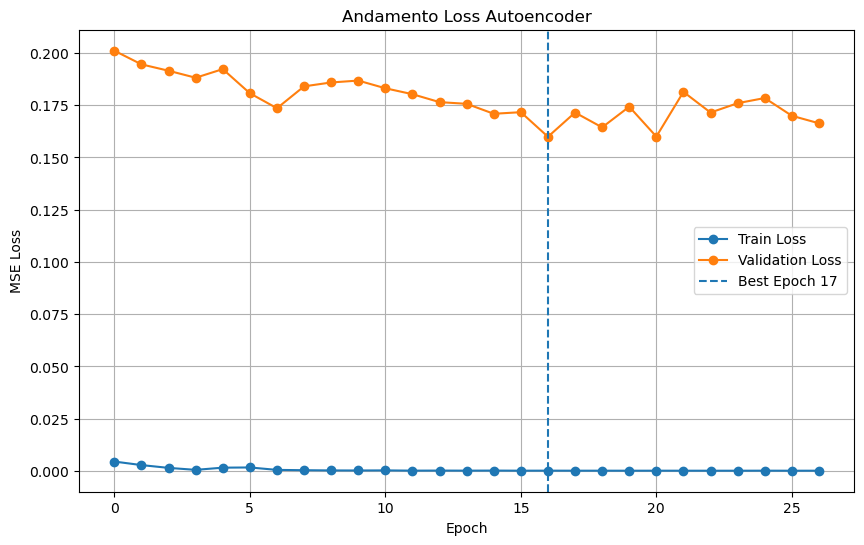

In [9]:
# ==========================================================
# BLOCCO 9: Autoencoder stabile con seed fisso, reset TF,
# EarlyStopping, logging avanzato e salvataggio embeddings
# ==========================================================

import os, gc, random, time
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt

# --- ✅ Determinismo per stabilità ---
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
tf.config.experimental.enable_op_determinism()

# --- ✅ Reset memoria e sessione ---
tf.keras.backend.clear_session()
gc.collect()

print("🏗️ Avvio Autoencoder con training riproducibile...")

# 1️⃣ Parametri
input_dim = X_scaled.shape[1]
latent_dim = 16
epochs = 40
batch_size = 64
validation_split = 0.1

# 2️⃣ Costruzione autoencoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(latent_dim, activation='relu', name='latent_vector')(encoded)

decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(0.001), loss='mse')

# 3️⃣ EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=1e-4,
    restore_best_weights=True,
    verbose=1
)

# 4️⃣ Logger
class ProgressLogger(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_logs = []

    def on_epoch_begin(self, epoch, logs=None):
        self.start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        t = time.time() - self.start
        self.epoch_logs.append({
            'epoch': epoch + 1,
            'loss': logs['loss'],
            'val_loss': logs['val_loss'],
            'time_s': t
        })
        bar = "━" * (30 * (epoch+1) // self.params['epochs'])
        bar += "-" * (30 - len(bar))
        print(f"Epoch {epoch+1}/{epochs} [{bar}] loss={logs['loss']:.6f} val={logs['val_loss']:.6f} time={t:.2f}s")

logger = ProgressLogger()

# 5️⃣ ✅ Training (shuffle OFF per stabilità)
history = autoencoder.fit(
    X_scaled, X_scaled,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    shuffle=False,
    callbacks=[early_stop, logger],
    verbose=0
)

print("\n✅ Training completato.")

# 6️⃣ Best epoch
best_idx = np.argmin(history.history['val_loss'])
print(f"🏆 Best epoch: {best_idx + 1}")
print(f"   Train loss: {history.history['loss'][best_idx]:.6f}")
print(f"   Val loss: {history.history['val_loss'][best_idx]:.6f}")
print(f"   Time per epoch: {logger.epoch_logs[best_idx]['time_s']:.2f}s")

# 7️⃣ Estrazione modello encoder
encoder = Model(inputs=input_layer, outputs=autoencoder.get_layer('latent_vector').output)

# 8️⃣ Embeddings latenti
X_latent = encoder.predict(X_scaled, verbose=0)
latent_cols = [f'latent_{i}' for i in range(latent_dim)]
X_embeddings = pd.DataFrame(X_latent, columns=latent_cols)

# 9️⃣ Salvataggio embeddings
np.save(r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\X_autoencoder_latent.npy", X_latent)
np.save(r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\labels.npy", data['label_technique'].values)

print(f"💾 Salvati {X_embeddings.shape[0]} embeddings da {latent_dim} dimensioni")

# 🔟 Grafico Train vs Val Loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label="Train Loss", marker="o")
plt.plot(history.history['val_loss'], label="Validation Loss", marker="o")
plt.axvline(best_idx, linestyle="--", label=f"Best Epoch {best_idx+1}")
plt.title("Andamento Loss Autoencoder")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()


📊 Analisi esplorativa degli embeddings latenti...
🔹 Varianza spiegata PCA: PC1 = 66.95% | PC2 = 16.30%


C:\Users\maria\AppData\Local\Temp\ipykernel_14756\2989630163.py:46: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from current font.
  plt.tight_layout()
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


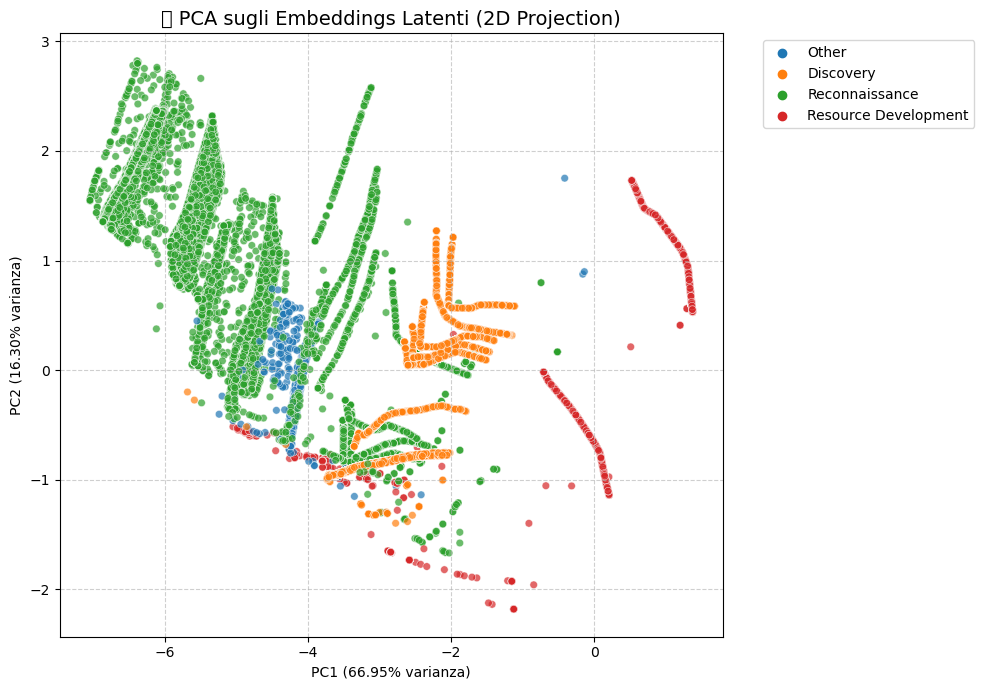

⚙️ Esecuzione t-SNE (potrebbe richiedere 1-2 minuti)...


C:\Users\maria\AppData\Local\Temp\ipykernel_14756\2989630163.py:95: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from current font.
  plt.tight_layout()
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


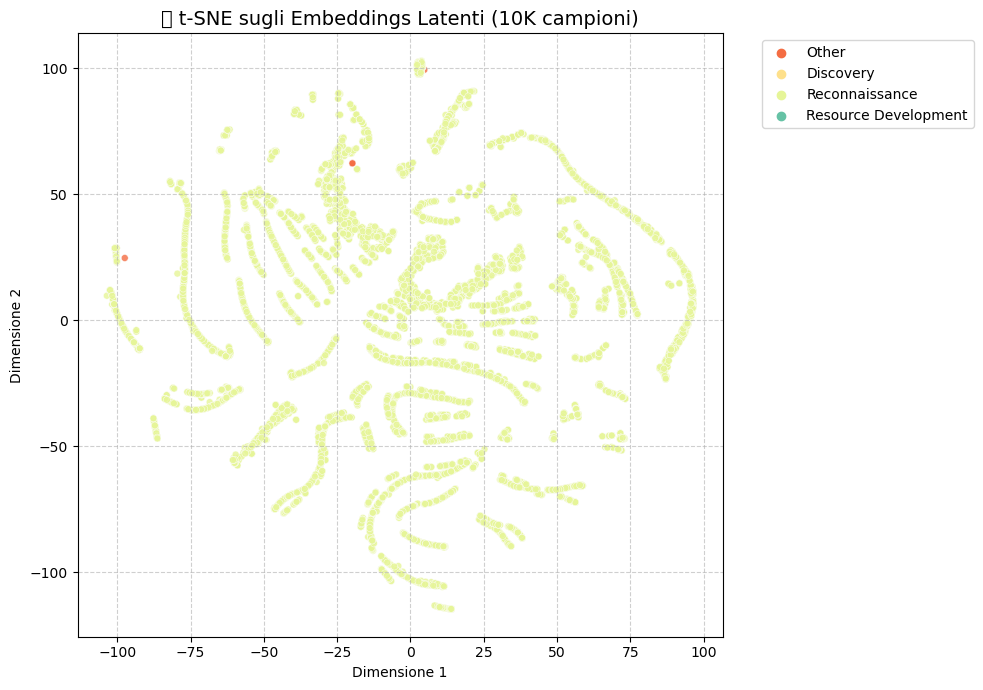

,mean,std,min,max
latent_0,0.034586,0.197865,0.0,3.554034
latent_1,3.290101,1.261630,0.0,4.413107
latent_2,0.108461,0.176031,0.0,4.772242
latent_3,0.203508,0.546016,0.0,7.039928
latent_4,2.066186,0.888698,0.0,4.451644
latent_5,2.613748,0.931777,0.0,4.087889
latent_6,0.011597,0.111887,0.0,2.707830
latent_7,0.010804,0.090357,0.0,2.657912
latent_8,0.084860,0.377779,0.0,3.019432
latent_9,0.129898,0.509804,0.0,4.359233


C:\Users\maria\AppData\Local\Temp\ipykernel_14756\2989630163.py:110: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


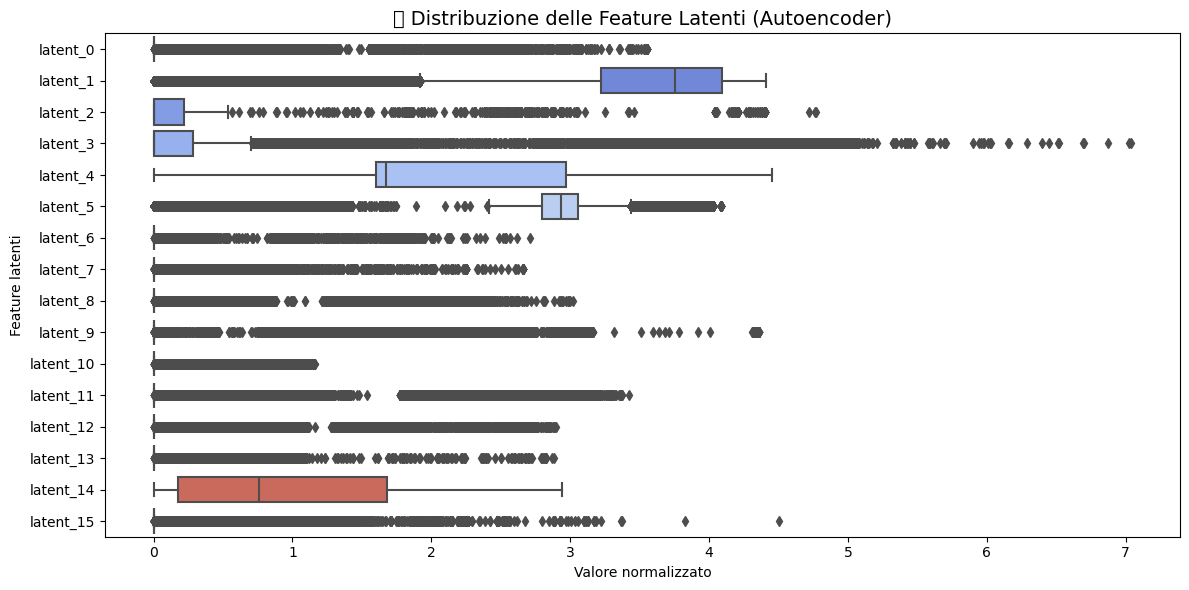

✅ Analisi embeddings completata con successo.


In [10]:
# ==========================================================
# BLOCCO 10: Analisi e Visualizzazione degli Embeddings Latenti (Autoencoder)
# ==========================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd

print("📊 Analisi esplorativa degli embeddings latenti...")

# 1️⃣ Caricamento embeddings (se serve)
# Se hai già in memoria X_embeddings, puoi saltare questa riga
# X_latent = np.load(r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\X_autoencoder_latent.npy")
# X_embeddings = pd.DataFrame(X_latent, columns=[f'latent_{i}' for i in range(X_latent.shape[1])])

# Aggiunta etichette (se presenti nel dataset originale)
if 'label_tactic' in data.columns:
    X_embeddings['label_tactic'] = data['label_tactic'].values
if 'label_technique' in data.columns:
    X_embeddings['label_technique'] = data['label_technique'].values


# ----------------------------------------------------------
# 2️⃣ PCA - Riduzione lineare della dimensionalità
# ----------------------------------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_latent)
explained_var = pca.explained_variance_ratio_ * 100
print(f"🔹 Varianza spiegata PCA: PC1 = {explained_var[0]:.2f}% | PC2 = {explained_var[1]:.2f}%")

pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'label_tactic': data['label_tactic'].values if 'label_tactic' in data.columns else 'unknown'
})

plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='label_tactic', palette='tab10', s=30, alpha=0.7)
plt.title("🌈 PCA sugli Embeddings Latenti (2D Projection)", fontsize=14)
plt.xlabel(f"PC1 ({explained_var[0]:.2f}% varianza)")
plt.ylabel(f"PC2 ({explained_var[1]:.2f}% varianza)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# ----------------------------------------------------------
# 3️⃣ t-SNE - Visualizzazione non lineare
# ----------------------------------------------------------
print("⚙️ Esecuzione t-SNE (potrebbe richiedere 1-2 minuti)...")

try:
    tsne = TSNE(
        n_components=2,
        perplexity=30,
        max_iter=1000,
        learning_rate='auto',
        random_state=42
    )
except TypeError:
    tsne = TSNE(
        n_components=2,
        perplexity=30,
        n_iter=1000,
        random_state=42
    )

X_tsne = tsne.fit_transform(X_latent[:10000])  # usa un campione per velocità

tsne_df = pd.DataFrame({
    'Dim1': X_tsne[:, 0],
    'Dim2': X_tsne[:, 1],
    'label_tactic': data['label_tactic'].values[:10000]
        if 'label_tactic' in data.columns else 'unknown'
})

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=tsne_df,
    x='Dim1',
    y='Dim2',
    hue='label_tactic',
    palette='Spectral',
    s=25,
    alpha=0.8
)
plt.title("🌀 t-SNE sugli Embeddings Latenti (10K campioni)", fontsize=14)
plt.xlabel("Dimensione 1")
plt.ylabel("Dimensione 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# ----------------------------------------------------------
# 5️⃣ Analisi statistica delle feature latenti
# ----------------------------------------------------------
latent_stats = X_embeddings.describe().T[['mean', 'std', 'min', 'max']]
display(latent_stats.head(10))

plt.figure(figsize=(12, 6))
sns.boxplot(data=X_embeddings.iloc[:, :16], orient='h', palette='coolwarm')
plt.title("📦 Distribuzione delle Feature Latenti (Autoencoder)", fontsize=14)
plt.xlabel("Valore normalizzato")
plt.ylabel("Feature latenti")
plt.tight_layout()
plt.show()

print("✅ Analisi embeddings completata con successo.")


⚙️ Avvio dello split e bilanciamento controllato (3 classi principali)...
⚠️ Colonne rimosse da X_embeddings (non numeriche o label-like): ['label_technique', 'label_tactic']
✅ Split completato.
 - X_train: (248027, 16)  | X_test: (62007, 16)
 - Distribuzione y_train: {'Resource Development': 209927, 'Discovery': 12816, 'Other': 2355, 'Reconnaissance': 22929}
 - Distribuzione y_test : {'Resource Development': 52482, 'Discovery': 3204, 'Other': 589, 'Reconnaissance': 5732}

🔹 Le 3 classi principali individuate: ['Resource Development', 'Reconnaissance', 'Discovery']
✅ Filtrati train/test sulle top3 classi: ['Resource Development', 'Reconnaissance', 'Discovery']
 - Nuova distribuzione y_train: {'Resource Development': 209927, 'Discovery': 12816, 'Reconnaissance': 22929}
 - Nuova distribuzione y_test : {'Resource Development': 52482, 'Discovery': 3204, 'Reconnaissance': 5732}

🔹 Classe più piccola ha 12816 campioni. Bilanciamento in corso...


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


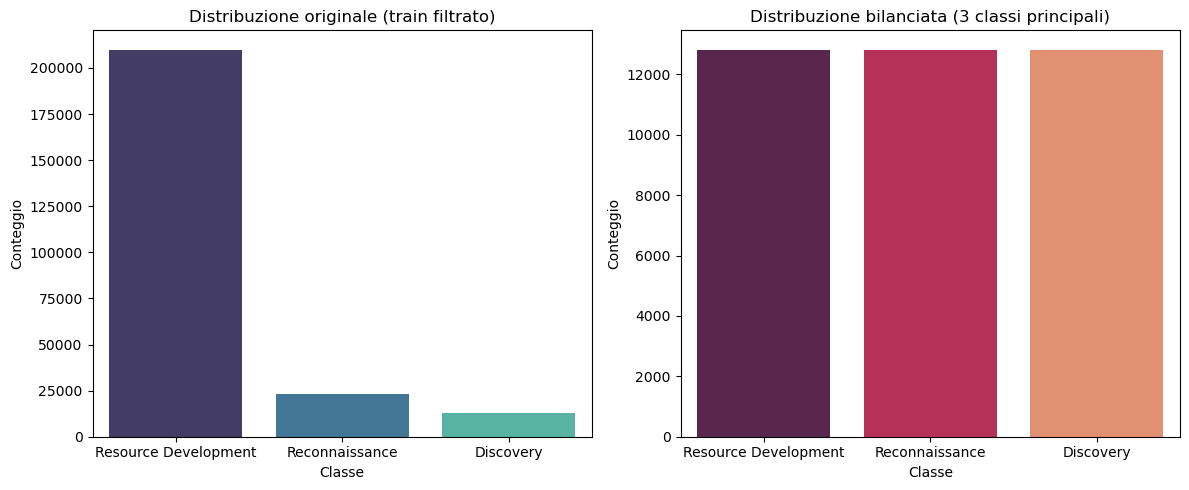


📁 Dataset salvati con successo in train_test_bal.npz
   → Contiene: train/test originali e train bilanciato con 3 classi principali.


In [11]:
# ==========================================================
# BLOCCO 11 ✅ DEFINITIVO
# Train/Test Split + Bilanciamento controllato (solo 3 classi principali)
# con pulizia automatica delle colonne non numeriche
# ==========================================================

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns

print("⚙️ Avvio dello split e bilanciamento controllato (3 classi principali)...")

# ----------------------------------------------------------
# 1️⃣ Selezione della label corretta
# ----------------------------------------------------------
# Se esiste la colonna 'label_tactic_reduced', usiamola; altrimenti 'label_tactic'
if 'label_tactic_reduced' in data.columns:
    y_label = data['label_tactic_reduced'].reset_index(drop=True)
else:
    y_label = data['label_tactic'].reset_index(drop=True)

# ----------------------------------------------------------
# 2️⃣ Pulizia delle feature numeriche
# ----------------------------------------------------------
# Elimina eventuali colonne non numeriche o identificatori da X_embeddings
if isinstance(X_embeddings, pd.DataFrame):
    non_numeric_cols = X_embeddings.select_dtypes(exclude=[np.number]).columns.tolist()
    label_like_cols = [c for c in X_embeddings.columns if any(x in c.lower() for x in ['label', 'uid', 'community'])]
    drop_cols = list(set(non_numeric_cols + label_like_cols))

    if drop_cols:
        print(f"⚠️ Colonne rimosse da X_embeddings (non numeriche o label-like): {drop_cols}")
        X_clean = X_embeddings.drop(columns=drop_cols)
    else:
        X_clean = X_embeddings

    X = X_clean.values
else:
    X = X_latent  # fallback nel caso tu abbia già un array latente
y = y_label.values

# ----------------------------------------------------------
# 3️⃣ Split stratificato (mantiene proporzione delle classi)
# ----------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("✅ Split completato.")
print(" - X_train:", X_train.shape, " | X_test:", X_test.shape)
print(" - Distribuzione y_train:", dict(collections.Counter(y_train)))
print(" - Distribuzione y_test :", dict(collections.Counter(y_test)))

# ----------------------------------------------------------
# 4️⃣ Conversione sicura dei tipi (solo float32 per numerici)
# ----------------------------------------------------------
X_train = np.asarray(X_train, dtype=np.float32)
X_test = np.asarray(X_test, dtype=np.float32)

# ----------------------------------------------------------
# 5️⃣ Identificazione delle 3 classi principali
# ----------------------------------------------------------
train_df = pd.DataFrame(X_train, columns=[f'latent_{i}' for i in range(X_train.shape[1])])
train_df['label'] = pd.Series(y_train).astype(str).str.strip()

class_counts = train_df['label'].value_counts()
top3_classes = class_counts.head(3).index.tolist()
print(f"\n🔹 Le 3 classi principali individuate: {top3_classes}")

# ----------------------------------------------------------
# 6️⃣ Filtraggio del dataset solo sulle top3 classi
# ----------------------------------------------------------
mask_train = np.isin(y_train, top3_classes)
mask_test = np.isin(y_test, top3_classes)

X_train = X_train[mask_train]
y_train = y_train[mask_train]
X_test = X_test[mask_test]
y_test = y_test[mask_test]

print(f"✅ Filtrati train/test sulle top3 classi: {top3_classes}")
print(" - Nuova distribuzione y_train:", dict(collections.Counter(y_train)))
print(" - Nuova distribuzione y_test :", dict(collections.Counter(y_test)))

# ----------------------------------------------------------
# 7️⃣ Bilanciamento controllato (undersampling)
# ----------------------------------------------------------
train_df = pd.DataFrame(X_train, columns=[f'latent_{i}' for i in range(X_train.shape[1])])
train_df['label'] = pd.Series(y_train).astype(str).str.strip()

valid_counts = train_df['label'].value_counts()
valid_top3 = [cls for cls in top3_classes if cls in valid_counts.index and valid_counts[cls] > 0]

if len(valid_top3) < 2:
    raise ValueError(f"❌ Bilanciamento impossibile: classi valide trovate solo {valid_top3}")

min_class_size = valid_counts[valid_top3].min()
print(f"\n🔹 Classe più piccola ha {min_class_size} campioni. Bilanciamento in corso...")

balanced_list = []
for cls in valid_top3:
    cls_df = train_df[train_df['label'] == cls]
    cls_bal = resample(cls_df, replace=False, n_samples=min_class_size, random_state=42)
    balanced_list.append(cls_bal)

train_balanced_df = pd.concat(balanced_list).sample(frac=1, random_state=42).reset_index(drop=True)

X_train_bal = train_balanced_df.drop(columns=['label']).apply(pd.to_numeric, errors='coerce').values.astype(np.float32)
y_train_bal = train_balanced_df['label'].astype(str).values

# ----------------------------------------------------------
# 8️⃣ Visualizzazione grafica delle distribuzioni
# ----------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x=y_train, order=top3_classes, ax=axes[0], palette="mako")
axes[0].set_title("Distribuzione originale (train filtrato)")
axes[0].set_xlabel("Classe")
axes[0].set_ylabel("Conteggio")

sns.countplot(x=y_train_bal, order=top3_classes, ax=axes[1], palette="rocket")
axes[1].set_title("Distribuzione bilanciata (3 classi principali)")
axes[1].set_xlabel("Classe")
axes[1].set_ylabel("Conteggio")

plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# 9️⃣ Salvataggio dataset bilanciati e originali
# ----------------------------------------------------------
np.savez_compressed(
    r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\train_test_bal.npz",
    X_train=X_train.astype(np.float32),
    X_test=X_test.astype(np.float32),
    y_train=y_train.astype(str),
    y_test=y_test.astype(str),
    X_train_bal=X_train_bal,
    y_train_bal=y_train_bal
)

print("\n📁 Dataset salvati con successo in train_test_bal.npz")
print("   → Contiene: train/test originali e train bilanciato con 3 classi principali.")


📊 Riepilogo distribuzione classi (train set):


,Classe,Conteggio originale,Conteggio bilanciato
0,Resource Development,209927,12816
1,Reconnaissance,22929,12816
2,Discovery,12816,12816


C:\Users\maria\AppData\Local\Temp\ipykernel_14756\2092122580.py:35: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


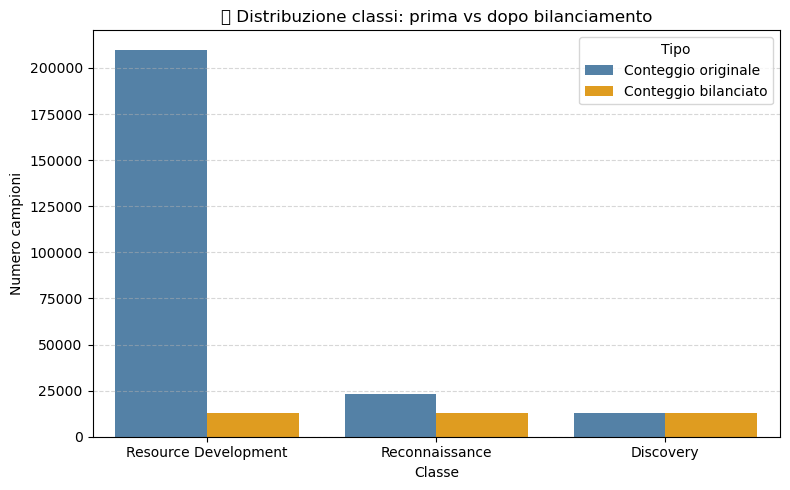

In [12]:
# ==========================================================
# BLOCCO 12: Riepilogo distribuzione classi (prima e dopo bilanciamento)
# ==========================================================
import pandas as pd

# Conteggi originali (solo top3 classi)
original_counts = pd.Series(y_train).value_counts()[top3_classes]

# Conteggi bilanciati
balanced_counts = pd.Series(y_train_bal).value_counts()[top3_classes]

# Creazione DataFrame riepilogo
summary_df = pd.DataFrame({
    "Classe": top3_classes,
    "Conteggio originale": original_counts.values,
    "Conteggio bilanciato": balanced_counts.values
})

# Mostra la tabella
print("📊 Riepilogo distribuzione classi (train set):")
display(summary_df)

# Grafico a barre comparativo (opzionale)
import matplotlib.pyplot as plt
import seaborn as sns

summary_melted = summary_df.melt(id_vars='Classe', var_name='Tipo', value_name='Conteggio')

plt.figure(figsize=(8,5))
sns.barplot(data=summary_melted, x='Classe', y='Conteggio', hue='Tipo', palette=['steelblue','orange'])
plt.title("📈 Distribuzione classi: prima vs dopo bilanciamento")
plt.ylabel("Numero campioni")
plt.xlabel("Classe")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


⚙️ Avvio split, pulizia e calcolo class weights (versione semplice)...
⚠️ Colonne rimosse da X_embeddings: ['label_tactic', 'label_technique']
✅ Split completato.
 - X_train: (248027, 16) | X_test: (62007, 16)
 - Distribuzione y_train: {'Resource Development': 209927, 'Discovery': 12816, 'Other': 2355, 'Reconnaissance': 22929}
 - Distribuzione y_test : {'Resource Development': 52482, 'Discovery': 3204, 'Other': 589, 'Reconnaissance': 5732}

📏 Class weights calcolati:
 - Discovery           : 4.8382
 - Other               : 26.3298
 - Reconnaissance      : 2.7043
 - Resource Development: 0.2954


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


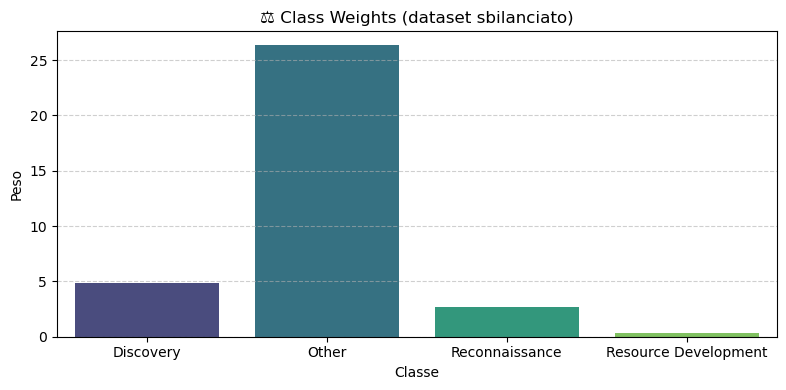


📁 Salvati:
   - train_test_unbal.npz → dataset sbilanciato (train/test originali)
   - class_weights_unbal.npy → pesi per classe
   - class_weights_plot.png → grafico salvato in:
     C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\class_weights_plot.png

✅ BLOCCO COMPLETATO SENZA ERRORI.


In [13]:
# ==========================================================
# BLOCCO FINALE ✅
# Dataset sbilanciato — calcolo class weights base + grafico
# ==========================================================
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

print("⚙️ Avvio split, pulizia e calcolo class weights (versione semplice)...")

# ----------------------------------------------------------
# 1️⃣ Selezione label corretta
# ----------------------------------------------------------
if 'label_tactic_reduced' in data.columns:
    y_label = data['label_tactic_reduced'].reset_index(drop=True)
else:
    y_label = data['label_tactic'].reset_index(drop=True)

# ----------------------------------------------------------
# 2️⃣ Pulizia feature numeriche da X_embeddings
# ----------------------------------------------------------
if isinstance(X_embeddings, pd.DataFrame):
    X_df = X_embeddings.copy()
else:
    X_df = pd.DataFrame(X_latent)

# Rimuove colonne non numeriche o che contengono label/id
non_numeric = X_df.select_dtypes(exclude=[np.number]).columns.tolist()
label_like = [c for c in X_df.columns if any(x in c.lower() for x in ['label', 'uid', 'id', 'community', 'technique', 'tactic'])]
drop_cols = list(dict.fromkeys(non_numeric + label_like))
if drop_cols:
    print(f"⚠️ Colonne rimosse da X_embeddings: {drop_cols}")
    X_df = X_df.drop(columns=drop_cols)

X_df = X_df.fillna(0)
X = X_df.values.astype(np.float32)
y = y_label.values

# ----------------------------------------------------------
# 3️⃣ Split stratificato
# ----------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Split completato.")
print(" - X_train:", X_train.shape, "| X_test:", X_test.shape)
print(" - Distribuzione y_train:", dict(collections.Counter(y_train)))
print(" - Distribuzione y_test :", dict(collections.Counter(y_test)))

# ----------------------------------------------------------
# 4️⃣ Calcolo class weights base (frequenza inversa)
# ----------------------------------------------------------
classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, weights))

print("\n📏 Class weights calcolati:")
for cls, w in class_weight_dict.items():
    print(f" - {cls:<20}: {w:.4f}")

# ----------------------------------------------------------
# 5️⃣ Visualizzazione class weights
# ----------------------------------------------------------
plt.figure(figsize=(8,4))
sns.barplot(x=list(class_weight_dict.keys()), y=list(class_weight_dict.values()), palette="viridis")
plt.title("⚖️ Class Weights (dataset sbilanciato)")
plt.ylabel("Peso")
plt.xlabel("Classe")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

save_path = r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\class_weights_plot.png"
plt.savefig(save_path, dpi=300)
plt.show()

# ----------------------------------------------------------
# 6️⃣ Salvataggio risultati
# ----------------------------------------------------------
np.savez_compressed(
    r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\train_test_unbal.npz",
    X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
)
np.save(r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\class_weights_unbal.npy", class_weight_dict)

print("\n📁 Salvati:")
print("   - train_test_unbal.npz → dataset sbilanciato (train/test originali)")
print("   - class_weights_unbal.npy → pesi per classe")
print(f"   - class_weights_plot.png → grafico salvato in:\n     {save_path}")
print("\n✅ BLOCCO COMPLETATO SENZA ERRORI.")
